In [1]:
%reset -f
import pandas as pd
import numpy as np



In [2]:
def input_for_Q1(filepath):
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    return df

def compute_ranking_return(group):
    group = group.sort_values('date')
    rolling_ret = (
        (1 + group['RET'].fillna(0)).shift(2).rolling(window=11)
        .apply(np.prod, raw=True) - 1
    )
    group['Ranking_Ret'] = rolling_ret
    return group


def PS3_Q1(df):
    int_columns = [
    'PERMNO',
    'SHRCD',
    'EXCHCD',
    'RET',
    'DLRET',
    'PRC',
    'SHROUT'
    ]
    df[int_columns] = df[int_columns].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    
    df = df[df['SHRCD'].isin([10, 11])]
    df = df[df['EXCHCD'].isin([1, 2, 3])]
    df = df.sort_values(['PERMNO', 'date'])
    
    df['RET_FULL'] = (1 + df['RET'].fillna(0)) * (1 + df['DLRET'].fillna(0)) - 1
    df['MC'] = df['PRC'].abs() * df['SHROUT']
    df['lag_Mkt_Cap'] = df.groupby('PERMNO')['MC'].shift(1)
    
    df = df.groupby('PERMNO').apply(compute_ranking_return)
    df = df.reset_index(drop=True)
    
    df = df.rename(columns={'RET_FULL': 'Ret'})
    df = df[['Year', 'Month', 'PERMNO', 'EXCHCD', 'lag_Mkt_Cap', 'Ret', 'Ranking_Ret']]
    df['lag_Mkt_Cap'] = df['lag_Mkt_Cap'] / 1e6
    df = df.dropna(subset=['Ranking_Ret'])
    df = df[(df['Year'] >= 1927) & (df['Year'] <= 2024)]
    return df
    
    
    

In [3]:
filepath = r"C:\Users\vikal\OneDrive - University of California\Documents\MFE-III\QAM\PS3\CRSP_monthly_equity_1926_2024.csv"
output_Q1 = PS3_Q1(input_for_Q1(filepath))

C:\Users\vikal\AppData\Local\Temp\ipykernel_23192\4204157569.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('PERMNO').apply(compute_ranking_return)


In [4]:
output_Q1

,Year,Month,PERMNO,EXCHCD,lag_Mkt_Cap,Ret,Ranking_Ret
12,1987,1,10000,3.0,0.001982,-0.212121,-0.810714
13,1987,2,10000,3.0,0.001582,0.000000,-0.882143
14,1987,3,10000,3.0,0.001582,-0.384615,-0.875000
15,1987,4,10000,3.0,0.000973,-0.062500,-0.908451
16,1987,5,10000,3.0,0.000912,-0.066667,-0.937500
...,...,...,...,...,...,...,...
3829768,2024,8,93436,3.0,741.380137,-0.077390,-0.260067
3829769,2024,9,93436,3.0,684.004370,0.221942,-0.100783
3829770,2024,10,93436,3.0,839.047410,-0.045025,-0.144312
3829771,2024,11,93436,3.0,802.033523,0.381469,0.302679


In [5]:
import pandas as pd
import numpy as np

def PS3_Q2(df):
    """
    Calculates monthly deciles for stocks based on their 'Ranking_Ret'.

    The function computes two types of deciles: 'DM_decile' and 'KRF_decile'.
    It processes the input DataFrame month by month.

    - 'DM_decile': Stocks are sorted into 10 deciles based on their 'Ranking_Ret'
      within the full universe of stocks for that specific month.
    - 'KRF_decile': Decile breakpoints are determined using 'Ranking_Ret' from
      NYSE-listed stocks (EXCHCD == 1) only for that month. These NYSE-based
      breakpoints are then used to assign all stocks (NYSE, AMEX, NASDAQ)
      in that month to one of the 10 deciles. If there are fewer than 10
      NYSE stocks in a given month, 'KRF_decile' will be NaN for all stocks
      in that month.

    Parameters:
    ----------
    df : pd.DataFrame
        Input DataFrame containing stock data. Must include the following columns:
        - 'Ranking_Ret': The variable used for ranking (e.g., past returns).
        - 'EXCHCD': Exchange code (1 for NYSE, 2 for AMEX, 3 for NASDAQ).
        - 'Year': The year of the observation.
        - 'Month': The month of the observation.
        Other columns (e.g., stock identifiers like 'PERMNO') will be preserved.

    Returns:
    -------
    pd.DataFrame
        The original DataFrame with two additional columns:
        - 'DM_decile': Integer decile (1-10) based on full universe sort. NaN if undecidable.
        - 'KRF_decile': Integer decile (1-10) based on NYSE breakpoints. NaN if undecidable.
        Both decile columns are of type 'Int64' (supports pd.NA).
    """
    working_df = df.copy()

    def assign_deciles_to_group(monthly_group_df):
        """
        Assigns DM_decile and KRF_decile to the given monthly group of stocks.
        """
        try:
            monthly_group_df['DM_decile'] = pd.qcut(monthly_group_df['Ranking_Ret'], 10, labels=False, duplicates='drop') + 1
        except ValueError:
            monthly_group_df['DM_decile'] = np.nan

        nyse_stocks_in_group_df = monthly_group_df[monthly_group_df['EXCHCD'] == 1]

        if nyse_stocks_in_group_df.shape[0] >= 10:
            try:
                krf_decile_breakpoints = pd.qcut(nyse_stocks_in_group_df['Ranking_Ret'], 10, retbins=True, duplicates='drop')[1]
                monthly_group_df['KRF_decile'] = pd.cut(monthly_group_df['Ranking_Ret'], bins=krf_decile_breakpoints, labels=False, include_lowest=True) + 1
            except ValueError:
                monthly_group_df['KRF_decile'] = np.nan
        else:
            monthly_group_df['KRF_decile'] = np.nan
            
        return monthly_group_df

    working_df = working_df.groupby(['Year', 'Month'], group_keys=False).apply(assign_deciles_to_group)

    working_df['DM_decile'] = working_df['DM_decile'].astype('Int64')
    working_df['KRF_decile'] = working_df['KRF_decile'].astype('Int64')

    return working_df
output_Q2 = PS3_Q2(output_Q1)
copy  = output_Q2.copy()
copy = copy.sort_values(["Year", "Month"]).reset_index(drop=True)
copy

C:\Users\vikal\AppData\Local\Temp\ipykernel_23192\644662758.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  working_df = working_df.groupby(['Year', 'Month'], group_keys=False).apply(assign_deciles_to_group)


,Year,Month,PERMNO,EXCHCD,lag_Mkt_Cap,Ret,Ranking_Ret,DM_decile,KRF_decile
0,1927,1,10006,1.0,0.060900,-0.013547,0.016859,6,6
1,1927,1,10014,1.0,0.001837,0.000000,-0.148149,4,4
2,1927,1,10022,1.0,0.011424,-0.075893,0.118208,8,8
3,1927,1,10030,1.0,0.021450,0.009545,0.009254,6,6
4,1927,1,10057,1.0,0.003063,-0.051020,-0.591837,1,1
...,...,...,...,...,...,...,...,...,...
3513085,2024,12,93374,1.0,7.225731,-0.102210,0.114412,6,5
3513086,2024,12,93397,3.0,0.501317,-0.117446,0.710236,9,10
3513087,2024,12,93426,1.0,0.280602,0.021768,-0.238766,3,2
3513088,2024,12,93434,3.0,0.016102,0.133333,-0.815749,1,1


In [6]:
ff_path = r"C:\Users\vikal\OneDrive - University of California\Documents\MFE-III\QAM\PS1\F-F_Research_Data_Factors.CSV"
ff = pd.read_csv(ff_path)
ff['Date'] = ff['Date'].astype(str)
ff['Year'] = ff['Date'].str[:4].astype(int)
ff['Month'] = ff['Date'].str[4:].astype(int)
ff['Market_minus_Rf'] = ff['Mkt-RF'] / 100
ff['Rf'] = ff['RF'] / 100
ff[['SMB', 'HML']] /= 100
ff = ff[['Year', 'Month', 'Market_minus_Rf', 'SMB', 'HML', 'Rf']]
ff

,Year,Month,Market_minus_Rf,SMB,HML,Rf
0,1926,7,0.0296,-0.0256,-0.0243,0.0022
1,1926,8,0.0264,-0.0117,0.0382,0.0025
2,1926,9,0.0036,-0.0140,0.0013,0.0023
3,1926,10,-0.0324,-0.0009,0.0070,0.0032
4,1926,11,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...,...,...
1177,2024,8,0.0161,-0.0355,-0.0113,0.0048
1178,2024,9,0.0174,-0.0017,-0.0259,0.0040
1179,2024,10,-0.0097,-0.0101,0.0089,0.0039
1180,2024,11,0.0651,0.0463,-0.0005,0.0040


In [7]:
def PS3_Q3(CRSP_Stocks_Momentum_decile, ff):
    import pandas as pd

    CRSP_Stocks_Momentum_decile = CRSP_Stocks_Momentum_decile.copy()
    ff = ff.copy()

    # Ensure proper dtypes
    CRSP_Stocks_Momentum_decile[['DM_decile', 'KRF_decile']] = CRSP_Stocks_Momentum_decile[['DM_decile', 'KRF_decile']].astype('Int64')

    # Value weight
    CRSP_Stocks_Momentum_decile['weight'] = CRSP_Stocks_Momentum_decile['lag_Mkt_Cap']

    # Function to compute decile returns
    def compute_returns(group, decile_col, ret_col):
        returns = group.groupby(['Year', 'Month', decile_col]).apply(
            lambda x: (x['Ret'] * x['weight']).sum() / x['weight'].sum()
        ).reset_index(name=ret_col)
        return returns

    # DM returns
    dm_ret = compute_returns(CRSP_Stocks_Momentum_decile, 'DM_decile', 'DM_Ret')
    dm_ret = dm_ret.rename(columns={'DM_decile': 'decile'})

    # KRF returns
    krf_ret = compute_returns(CRSP_Stocks_Momentum_decile, 'KRF_decile', 'KRF_Ret')
    krf_ret = krf_ret.rename(columns={'KRF_decile': 'decile'})

    # Merge
    merged = pd.merge(dm_ret, krf_ret, on=['Year', 'Month', 'decile'], how='outer')

    # Merge with Rf
    out = pd.merge(merged, ff[['Year', 'Month', 'Rf']], on=['Year', 'Month'], how='left')
    out = out.sort_values(['Year', 'Month', 'decile']).reset_index(drop=True)
    return out

In [8]:
output_Q3 = PS3_Q3(output_Q2, ff)
output_Q3

C:\Users\vikal\AppData\Local\Temp\ipykernel_23192\1762837716.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  returns = group.groupby(['Year', 'Month', decile_col]).apply(
C:\Users\vikal\AppData\Local\Temp\ipykernel_23192\1762837716.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  returns = group.groupby(['Year', 'Month', decile_col]).apply(


,Year,Month,decile,DM_Ret,KRF_Ret,Rf
0,1927,1,1,-0.032221,-0.032221,0.0025
1,1927,1,2,-0.031600,-0.031600,0.0025
2,1927,1,3,0.035110,0.035110,0.0025
3,1927,1,4,-0.003290,-0.003290,0.0025
4,1927,1,5,-0.005089,-0.005089,0.0025
...,...,...,...,...,...,...
11755,2024,12,6,-0.017361,-0.013201,0.0037
11756,2024,12,7,-0.007601,0.001766,0.0037
11757,2024,12,8,-0.062622,-0.058307,0.0037
11758,2024,12,9,-0.047687,-0.055969,0.0037


In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew

def PS3_Q4(crsp_df: pd.DataFrame, dm_df: pd.DataFrame) -> pd.DataFrame:
    """
    Replicates part of Table 1 from Daniel & Moskowitz (2016), computing summary stats for DM deciles and WML.

    Parameters:
    - crsp_df: DataFrame with CRSP-based returns. Must include ['Year', 'Month', 'decile', 'DM_Ret', 'Rf'].
    - dm_df: DataFrame with Daniel-Moskowitz benchmark returns. Same format.

    Returns:
    - DataFrame with rows for mean excess return, volatility, Sharpe ratio, skewness, and correlation with DM.
    """
    # Filter for overlapping period
    crsp_df = crsp_df[(crsp_df['Year'] >= 1927) & (crsp_df['Year'] <= 2016)]

    # Merge for correlation
    merged = pd.merge(crsp_df, dm_df, on=['Year', 'Month', 'decile'], suffixes=('', '_DM'))

    stats = {
        'Mean Excess Return': [],
        'Volatility': [],
        'Sharpe Ratio': [],
        'Skewness': [],
        'Corr with DM': []
    }

    result_columns = []

    for d in range(1, 11):  # Deciles 1 to 10
        df_d = merged[merged['decile'] == d]
        ret = df_d['DM_Ret']
        rf = df_d['Rf']
        dm_ret = df_d['DM_Ret_DM']

        ex_ret = ret - rf
        stats['Mean Excess Return'].append(ex_ret.mean() * 12)
        stats['Volatility'].append(ex_ret.std() * np.sqrt(12))
        stats['Sharpe Ratio'].append((ex_ret.mean() / ex_ret.std()) * np.sqrt(12))
        stats['Skewness'].append(skew(np.log1p(ret)))
        stats['Corr with DM'].append(np.corrcoef(ret, dm_ret)[0, 1])
        result_columns.append(f'Decile {d}')

    # WML: Decile 10 - Decile 1
    wml_df = pd.merge(
        crsp_df[crsp_df['decile'] == 10],
        crsp_df[crsp_df['decile'] == 1],
        on=['Year', 'Month'],
        suffixes=('_10', '_1')
    )
    wml_ret = wml_df['DM_Ret_10'] - wml_df['DM_Ret_1']
    wml_rf = wml_df['Rf_10']

    ex_ret_wml = wml_ret - wml_rf
    dm_wml = dm_df[dm_df['decile'] == 10].merge(
        dm_df[dm_df['decile'] == 1], on=['Year', 'Month'], suffixes=('_10', '_1'))
    dm_wml_ret = dm_wml['DM_Ret_10'] - dm_wml['DM_Ret_1']

    stats['Mean Excess Return'].append(ex_ret_wml.mean() * 12)
    stats['Volatility'].append(ex_ret_wml.std() * np.sqrt(12))
    stats['Sharpe Ratio'].append((ex_ret_wml.mean() / ex_ret_wml.std()) * np.sqrt(12))
    stats['Skewness'].append(skew(np.log1p(wml_ret + wml_rf)))
    stats['Corr with DM'].append(np.corrcoef(wml_ret, dm_wml_ret)[0, 1])
    result_columns.append("WML")

    # Create final dataframe
    summary_df = pd.DataFrame(stats, index=result_columns).T
    return summary_df


In [10]:

file_path = r"C:\Users\vikal\OneDrive - University of California\Documents\MFE-III\QAM\PS3\DM_data_2017_03\m_m_pt_tot.txt"

dm_df = pd.read_csv(file_path, delim_whitespace=True, header=None,
                    names=['Date', 'decile', 'DM_Ret', 'lag_Mkt_Cap', 'n_firms'])

# Convert date to year and month
dm_df['Date'] = pd.to_datetime(dm_df['Date'], format='%Y%m%d')
dm_df['Year'] = dm_df['Date'].dt.year
dm_df['Month'] = dm_df['Date'].dt.month

# Optional: Keep only necessary columns
dm_df = dm_df[['Year', 'Month', 'decile', 'DM_Ret']]


C:\Users\vikal\AppData\Local\Temp\ipykernel_23192\4106347358.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dm_df = pd.read_csv(file_path, delim_whitespace=True, header=None,


In [11]:
output_Q4 = PS3_Q4(output_Q3, dm_df)
output_Q4_pct = output_Q4.copy()
rows_to_scale = ["Mean Excess Return", "Volatility"]
output_Q4_pct.loc[rows_to_scale] = output_Q4_pct.loc[rows_to_scale] * 100

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import skew

def PS3_Q5(crsp_df: pd.DataFrame, krf_df: pd.DataFrame) -> pd.DataFrame:
    """
    Replicates part of Table 1 from Daniel & Moskowitz (2016), using KRF_Ret and comparing with Kenneth French's KRF benchmark.

    Parameters:
    - crsp_df: DataFrame with CRSP-based KRF decile returns. Must include ['Year', 'Month', 'decile', 'KRF_Ret', 'Rf'].
    - krf_df: DataFrame with benchmark KRF returns from Kenneth French. Must include ['Year', 'Month', 'decile', 'KRF_Ret'].

    Returns:
    - DataFrame with rows for mean excess return, volatility, Sharpe ratio, skewness, and correlation with KRF benchmark.
    """

    # Filter for the common period
    crsp_df = crsp_df[(crsp_df['Year'] >= 1927) & (crsp_df['Year'] <= 2016)]

    # Merge for correlation purposes
    merged = pd.merge(crsp_df, krf_df, on=['Year', 'Month', 'decile'], suffixes=('', '_KRF'))

    stats = {
        'Mean Excess Return': [],
        'Volatility': [],
        'Sharpe Ratio': [],
        'Skewness': [],
        'Corr with KRF': []
    }

    result_columns = []

    for d in range(1, 11):
        df_d = merged[merged['decile'] == d]
        ret = df_d['KRF_Ret']
        rf = df_d['Rf']
        krf_bench = df_d['KRF_Ret_KRF']

        ex_ret = ret - rf
        stats['Mean Excess Return'].append(ex_ret.mean() * 12)
        stats['Volatility'].append(ex_ret.std() * np.sqrt(12))
        stats['Sharpe Ratio'].append((ex_ret.mean() / ex_ret.std()) * np.sqrt(12))
        stats['Skewness'].append(skew(np.log1p(ret)))
        stats['Corr with KRF'].append(np.corrcoef(ret, krf_bench)[0, 1])
        result_columns.append(f'Decile {d}')

    # WML: Decile 10 - Decile 1
    wml_df = pd.merge(
        crsp_df[crsp_df['decile'] == 10],
        crsp_df[crsp_df['decile'] == 1],
        on=['Year', 'Month'],
        suffixes=('_10', '_1')
    )
    wml_ret = wml_df['KRF_Ret_10'] - wml_df['KRF_Ret_1']
    wml_rf = wml_df['Rf_10']

    ex_ret_wml = wml_ret - wml_rf
    krf_wml = krf_df[krf_df['decile'] == 10].merge(
        krf_df[krf_df['decile'] == 1],
        on=['Year', 'Month'],
        suffixes=('_10', '_1')
    )
    krf_wml_ret = krf_wml['KRF_Ret_10'] - krf_wml['KRF_Ret_1']

    stats['Mean Excess Return'].append(ex_ret_wml.mean() * 12)
    stats['Volatility'].append(ex_ret_wml.std() * np.sqrt(12))
    stats['Sharpe Ratio'].append((ex_ret_wml.mean() / ex_ret_wml.std()) * np.sqrt(12))
    stats['Skewness'].append(skew(np.log1p(wml_ret)))
    stats['Corr with KRF'].append(np.corrcoef(wml_ret, krf_wml_ret)[0, 1])
    result_columns.append("WML")

    summary_df = pd.DataFrame(stats, index=result_columns).T
    return summary_df


In [13]:
# Loading KF data
df = pd.read_csv("KF_10_mom.csv")  # replace with actual filename

# Step 2: Split 'Date' into Year and Month
df['Year'] = df['Date'] // 100
df['Month'] = df['Date'] % 100

# Step 3: Reshape the decile columns into long format
long_df = df.melt(id_vars=['Date', 'Year', 'Month'], 
                  var_name='decile_name', 
                  value_name='KRF_Ret')

# Step 4: Map decile names to numeric values
decile_map = {
    'Lo PRIOR': 1,
    'PRIOR 2': 2,
    'PRIOR 3': 3,
    'PRIOR 4': 4,
    'PRIOR 5': 5,
    'PRIOR 6': 6,
    'PRIOR 7': 7,
    'PRIOR 8': 8,
    'PRIOR 9': 9,
    'Hi PRIOR': 10
}
long_df['decile'] = long_df['decile_name'].map(decile_map)

# Step 5: Convert returns from percent to decimal
long_df['KRF_Ret'] = long_df['KRF_Ret'] / 100

# Step 6: Final clean DataFrame
krf_returns = long_df[['Year', 'Month', 'decile', 'KRF_Ret']].sort_values(['Year', 'Month', 'decile'])
krf_returns = krf_returns.reset_index(drop=True)
krf_returns

,Year,Month,decile,KRF_Ret
0,1927,1,1,-0.0332
1,1927,1,2,-0.0446
2,1927,1,3,0.0269
3,1927,1,4,-0.0033
4,1927,1,5,-0.0041
...,...,...,...,...
11755,2024,12,6,-0.0132
11756,2024,12,7,0.0015
11757,2024,12,8,-0.0596
11758,2024,12,9,-0.0562


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import skew

def PS3_Q5(crsp_df: pd.DataFrame, krf_df: pd.DataFrame) -> pd.DataFrame:
    """
    Replicates part of Table 1 from Daniel & Moskowitz (2016), using KRF_Ret and comparing with Kenneth French's KRF benchmark.

    Parameters:
    - crsp_df: DataFrame with CRSP-based KRF decile returns. Must include ['Year', 'Month', 'decile', 'KRF_Ret', 'Rf'].
    - krf_df: DataFrame with benchmark KRF returns from Kenneth French. Must include ['Year', 'Month', 'decile', 'KRF_Ret'].

    Returns:
    - DataFrame with rows for mean excess return, volatility, Sharpe ratio, skewness, and correlation with KRF benchmark.
    """

    # Merge for correlation purposes
    merged = pd.merge(crsp_df, krf_df, on=['Year', 'Month', 'decile'], suffixes=('', '_KRF'))

    stats = {
        'Mean Excess Return': [],
        'Volatility': [],
        'Sharpe Ratio': [],
        'Skewness': [],
        'Corr with KRF': []
    }

    result_columns = []

    for d in range(1, 11):
        df_d = merged[merged['decile'] == d]
        ret = df_d['KRF_Ret']
        rf = df_d['Rf']
        krf_bench = df_d['KRF_Ret_KRF']

        ex_ret = ret - rf
        stats['Mean Excess Return'].append(ex_ret.mean() * 12)
        stats['Volatility'].append(ex_ret.std() * np.sqrt(12))
        stats['Sharpe Ratio'].append((ex_ret.mean() / ex_ret.std()) * np.sqrt(12))
        stats['Skewness'].append(skew(np.log1p(ret)))
        stats['Corr with KRF'].append(np.corrcoef(ret, krf_bench)[0, 1])
        result_columns.append(f'Decile {d}')

    # WML: Decile 10 - Decile 1
    wml_df = pd.merge(
        crsp_df[crsp_df['decile'] == 10],
        crsp_df[crsp_df['decile'] == 1],
        on=['Year', 'Month'],
        suffixes=('_10', '_1')
    )
    wml_ret = wml_df['KRF_Ret_10'] - wml_df['KRF_Ret_1']
    wml_rf = wml_df['Rf_10']

    ex_ret_wml = wml_ret - wml_rf
    krf_wml = krf_df[krf_df['decile'] == 10].merge(
        krf_df[krf_df['decile'] == 1],
        on=['Year', 'Month'],
        suffixes=('_10', '_1')
    )
    krf_wml_ret = krf_wml['KRF_Ret_10'] - krf_wml['KRF_Ret_1']

    stats['Mean Excess Return'].append(ex_ret_wml.mean() * 12)
    stats['Volatility'].append(ex_ret_wml.std() * np.sqrt(12))
    stats['Sharpe Ratio'].append((ex_ret_wml.mean() / ex_ret_wml.std()) * np.sqrt(12))
    stats['Skewness'].append(skew(np.log1p(wml_ret)))
    stats['Corr with KRF'].append(np.corrcoef(wml_ret, krf_wml_ret)[0, 1])
    result_columns.append("WML")

    summary_df = pd.DataFrame(stats, index=result_columns).T
    return summary_df


In [15]:
output_Q5 = PS3_Q5(output_Q3, krf_returns)
output_Q5_pct = output_Q5.copy()
rows_to_scale = ["Mean Excess Return", "Volatility"]
output_Q5_pct.loc[rows_to_scale] = output_Q5_pct.loc[rows_to_scale] * 100
output_Q5_pct

,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
Mean Excess Return,1.091836,5.654909,6.324232,7.647507,7.506716,8.242807,9.173403,10.207435,10.643213,14.941741,10.618375
Volatility,34.099962,27.820700,24.003917,21.787359,20.302709,19.791597,18.725924,18.201952,19.194729,22.093647,27.277467
Sharpe Ratio,0.032019,0.203263,0.263467,0.351007,0.369740,0.416480,0.489877,0.560788,0.554486,0.676291,0.389273
Skewness,0.147024,-0.116488,-0.114144,0.088878,-0.116761,-0.293579,-0.490576,-0.505217,-0.814819,-0.882631,-5.713892
Corr with KRF,0.998165,0.997976,0.997779,0.997752,0.997430,0.997675,0.996824,0.998058,0.998284,0.998727,0.996419


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

def momentum_recent_performance(df, start_year=2015, end_year=2024):
    # Filter for recent years
    recent_df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]

    # Pivot to get decile returns in columns
    pivot = recent_df.pivot_table(index=['Year', 'Month'], columns='decile', values='DM_Ret')

    # Calculate WML = Decile 10 - Decile 1
    pivot['WML'] = pivot[10] - pivot[1]

    # Compute performance stats
    wml = pivot['WML']
    mean_ret = wml.mean() * 12  # Annualized
    vol = wml.std() * np.sqrt(12)  # Annualized
    sharpe = mean_ret / vol
    skewness = skew(wml.dropna())

    # Print results
    print("Momentum Performance ({}–{}):".format(start_year, end_year))
    print(f"Annualized Mean Return: {mean_ret:.2%}")
    print(f"Annualized Volatility: {vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Skewness: {skewness:.2f}")

    # Plot cumulative return
    # Create proper datetime index
    pivot.index = pd.to_datetime([f"{y}-{m:02d}" for y, m in pivot.index])

    # Compute cumulative return
    cumulative = (1 + pivot['WML'].fillna(0)).cumprod()

    # Plot with fixed x-axis
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative.index, cumulative.values, label='Cumulative WML Return', color='navy')
    plt.title(f'Cumulative Momentum (WML) Return: {start_year}–{end_year}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.xticks(cumulative.index[::6], rotation=45)  # Show every 6th month
    plt.legend()
    plt.tight_layout()
    plt.show()

    
    return pivot, wml


Momentum Performance (2015–2024):
Annualized Mean Return: 20.54%
Annualized Volatility: 35.46%
Sharpe Ratio: 0.58
Skewness: -0.84


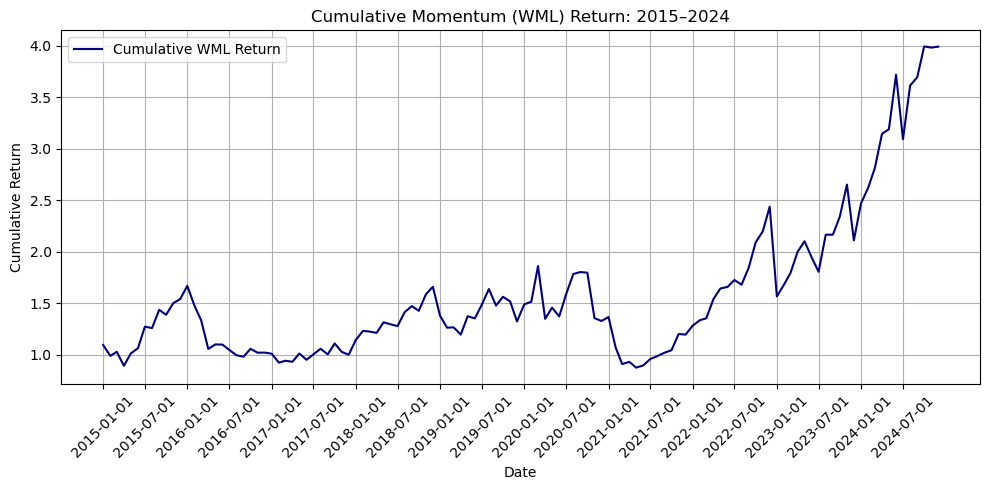

In [17]:
pivot_df, wml_series = momentum_recent_performance(output_Q3)
